# <center> Adherence in a RCT mHealth dataset </center>

### Introduction
Dieses Notebook stellt verschiedene Algorithmen zur Analyse des Adherence Verhaltens von Personen aus einem gegebenen Datensatz zur Verfügung.

### Imports
Damit wir alle benötigten Algorithmen und Funktionen auch aufrufen können, importieren wir zunächst alle Python Dateien, in denen unser Code geschrieben steht.

In [5]:
import sys
sys.path.append('C:/Users/mauri/PycharmProjects/Softwareprojekt/code')
from helper import *
from task3_prediction import *
from task4_statistics import *
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# FutureWarning-Warnungen ignorieren
warnings.filterwarnings("ignore", category=FutureWarning)

### Read in data
Zuerst lesen wir den Datensatz als pandas DataFrame ein. Der Datensatz muss in einem CSV-Format vorliegen. Dafür muss der gesamte Dateipfad zwischen den Hochkommas hinter "dataset =" eingesetzt werden.

In [6]:
dataset = 'C:/Users/mauri/PycharmProjects/Softwareprojekt/data/gefiltert.csv'

# Einlesen des Datensatzes als pandas DataFrame
df = pd.read_csv(dataset)

### Group and sort data
Um mit dem Datensatz besser arbeiten zu können müssen wir diesen zunächst etwas sortieren. Dafür gruppieren wir alle user_ids, sodass die Daten eines Nutzers alle hintereinander stehen und nicht quer verteilt sind und sortieren die Daten nach dem Datum von collected_at, sodass sie auch zeitlich richtig sortiert sind. Das Ergebnis wird in der Datei dataset_sorted.csv gespeichert.

In [7]:
# Gruppieren des DataFrame nach user_id und Sortieren nach collected_at
df_sorted = group_and_sort(df)

# Speichern des gruppierten und sortierten DataFrames in einer neuen CSV-Datei
df_sorted.to_csv("C:/Users/mauri/PycharmProjects/Softwareprojekt/data/dataset_sorted.csv", index=False)
df_sorted.head()

,id,user_id,locale,client,collected_at,created_at,updated_at,value_loudness,value_cumberness,value_jawbone,...,collected_at_cumberness,collected_at_jawbone,collected_at_neck,collected_at_tin_day,collected_at_tin_cumber,collected_at_tin_max,collected_at_movement,collected_at_stress,collected_at_emotion,collected_at_diary_q11
0,1104,2107,en,"{""name"":""UNITI 1.0"",""os"":""iOS 14.5.1"",""device""...",2021-05-14T15:48:21Z,2021-05-14T15:48:21Z,2021-05-14T15:48:21Z,35,3,0,...,2021-05-14T15:45:00Z,2021-05-14T15:46:03Z,2021-05-14T15:45:27Z,2021-05-14T15:46:12Z,2021-05-14T15:46:18Z,2021-05-14T15:46:24Z,2021-05-14T15:46:41Z,2021-05-14T15:46:44Z,2021-05-14T15:46:56Z,2021-05-14T15:48:02Z
1,1162,2107,de,"{""os"":""iOS 14.5.1"",""name"":""UNITI 1.0"",""device""...",2021-05-15T17:32:52Z,2021-05-15T17:32:53Z,2021-05-15T17:32:53Z,35,18,0,...,2021-05-15T17:30:57Z,2021-05-15T17:31:06Z,2021-05-15T17:30:49Z,2021-05-15T17:31:45Z,2021-05-15T17:31:48Z,2021-05-15T17:31:49Z,2021-05-15T17:32:09Z,2021-05-15T17:32:12Z,2021-05-15T17:32:16Z,2021-05-15T17:32:44Z
2,1217,2107,de,"{""os"":""iOS 14.5.1"",""name"":""UNITI 1.0"",""device""...",2021-05-16T17:31:08Z,2021-05-16T17:31:08Z,2021-05-16T17:31:08Z,37,31,0,...,2021-05-16T17:30:09Z,2021-05-16T17:30:13Z,2021-05-16T17:30:15Z,2021-05-16T17:30:20Z,2021-05-16T17:30:25Z,2021-05-16T17:30:28Z,2021-05-16T17:30:33Z,2021-05-16T17:30:36Z,2021-05-16T17:30:39Z,2021-05-16T17:31:00Z
3,1298,2107,de,"{""os"":""iOS 14.5.1"",""device"":""iPhone"",""name"":""U...",2021-05-17T19:12:20Z,2021-05-17T19:12:21Z,2021-05-17T19:12:21Z,26,22,0,...,2021-05-17T19:11:30Z,2021-05-17T19:11:34Z,2021-05-17T19:11:37Z,2021-05-17T19:11:43Z,2021-05-17T19:11:46Z,2021-05-17T19:11:49Z,2021-05-17T19:11:52Z,2021-05-17T19:11:56Z,2021-05-17T19:11:57Z,2021-05-17T19:12:11Z
4,1299,2107,de,"{""os"":""iOS 14.5.1"",""device"":""iPhone"",""name"":""U...",2021-05-17T19:13:10Z,2021-05-17T19:13:10Z,2021-05-17T19:13:10Z,22,28,0,...,2021-05-17T19:12:38Z,2021-05-17T19:12:47Z,2021-05-17T19:12:48Z,2021-05-17T19:12:52Z,2021-05-17T19:12:54Z,2021-05-17T19:12:57Z,2021-05-17T19:13:00Z,2021-05-17T19:13:02Z,2021-05-17T19:13:03Z,NaN


### Prediction of a users adherence behaviour
In dieser Task geht es darum die Adherence eines neuen Nutzers für einen bestimmten Tag y in der Zukunft vorherzusagen. Dies geschieht mithilfe der Daten des neuen Nutzers und mithilfe des Datensatzes. Zuerst lesen wir den Datensatz unseres Nutzers ein. Außerdem bringen wir den Datensatz in eine geeignete Form, indem wir alle Spalten ohne Mehrwert rauslöschen und alle möglichen Werte numerisch machen.

In [16]:
new_user = 'C:/Users/mauri/PycharmProjects/Softwareprojekt/data/new_user.csv'
df_newuser = pd.read_csv(new_user)

df_prediction = data_preparation(df)
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17597 entries, 0 to 17596
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   17597 non-null  int64              
 1   user_id              17597 non-null  int64              
 2   locale               17597 non-null  int64              
 3   client               17597 non-null  int64              
 4   collected_at         17597 non-null  datetime64[ns, UTC]
 5   value_loudness       17597 non-null  int64              
 6   value_cumberness     17597 non-null  int64              
 7   value_jawbone        17597 non-null  int64              
 8   value_neck           17597 non-null  int64              
 9   value_tin_day        17597 non-null  int64              
 10  value_tin_cumber     17597 non-null  int64              
 11  value_tin_max        17597 non-null  int64              
 12  value_movement    

#### Step 1
Im ersten Schritt suchen wir den Datensatz nach den k-ähnlichsten Personen zu unserem neuen Nutzer ab. Dabei suchen wir nach ähnlichen Adherence-Levels. Jeder Nutzer bekommt dann noch das Label "day_y_adherent", welches mit den Werten 1 (true) oder 0 (false) belegt werden kann und angibt, ob der Nutzer an Tag y adherent ist.

In [6]:
df_similarusers = find_similar_users(df_prediction, df_newuser, 5)

day_y = 20
df_similarusers = add_day_y_adherent(df_similarusers, day_y)

Die 5 ähnlichsten Nutzer sind:
     user_id  adherence_level
19    2107.0         0.863821
237  40362.0         0.866667
25   34242.0         0.859813
68   40176.0         0.868132
172  34131.0         0.858824


#### Step 2
Im zweiten Schritt trainieren wir einen SVM Klassifikator auf unseren ähnlichen Nutzern aus Step 1, der die Nutzer danach klassifiziert ob sie an Tag y adherent sind oder nicht.

In [11]:
svm_classifier = svm_classification(df_similarusers)

NameError: name 'svm_classification' is not defined

#### Step 3
Im dritten Schritt wollen wir für unseren neuen Nutzer mithilfe unseren in Step 2 trainierten Klassifikators festlegen, ob er an Tag y adherent sein wird oder nicht.

In [ ]:
prediction(svm_classifier, df_newuser)

### Statistics
In dieser Task geht es darum die Phasen und die Gruppen aus Task 1 und 2, sowie einige weitere Statistiken zu einem bestimmten Nutzer in einer Übersicht darzustellen.

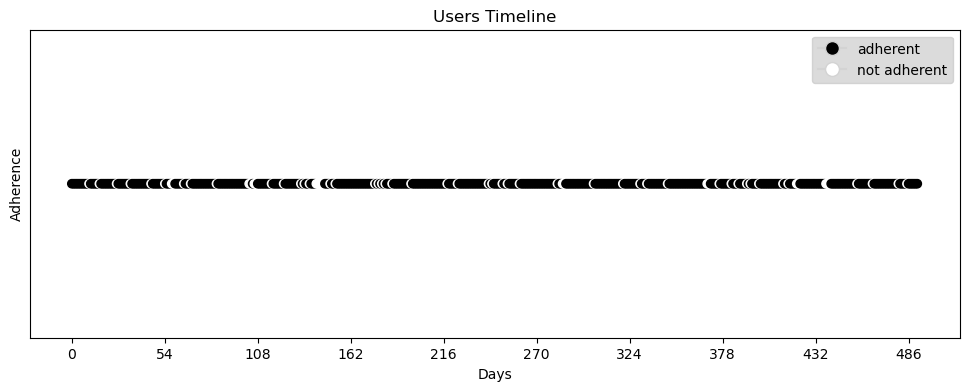

In [8]:
user_id = 2107
show_user_timeline(df_sorted, user_id)

# Tests

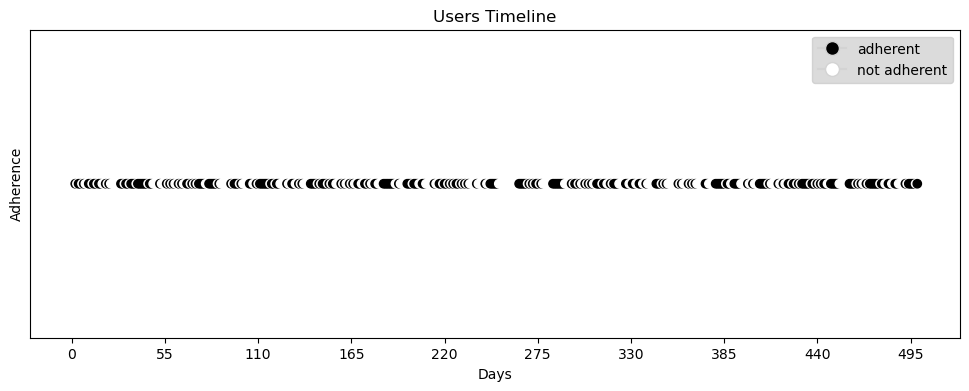

In [23]:
# Beispiel-Array mit 500 zufälligen Werten von 0 und 1
array = np.random.randint(2, size=500)

# X-Achse: Indizes der Elemente im Array
x = np.arange(len(array))

# Figure-Objekt erstellen und Größe festlegen
fig, ax = plt.subplots(figsize=(12, 4))

# Scatter Plot erstellen
ax.scatter(x, np.zeros_like(array), c=array, cmap='binary', marker='o')

# Achsentitel und Diagrammtitel festlegen
ax.set_xlabel('Days')
ax.set_ylabel('Adherence')
ax.set_title('Users Timeline')

# x-Achse beschriften
step = len(x) // 9
x_ticks = np.arange(0, len(x), step)
x_labels = np.arange(0, len(x), step)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# Achsenbeschriftungen ausblenden
ax.set_yticks([])

# Legende hinzufügen
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='lightgrey', markerfacecolor='k', markersize=10, label='adherent'),
    plt.Line2D([0], [0], marker='o', color='lightgrey', markerfacecolor='w', markersize=10, label='not adherent')]
plt.legend(handles=legend_elements, facecolor='lightgrey')

# Diagramm anzeigen
plt.show()